# Data labeling
This notebook shows how to conduct data labeling and content analysis using [EDSL](https://docs.expectedparrot.com), an open-source library for simulating surveys, experiments and other research with AI agents and large language models. 

Using a dataset of mock customer service tickets as an example, we demonstrate how to: 

1. Import data into EDSL 
2. Create questions about the data 
3. Design an AI agent to answer the questions
4. Select a language model to generate responses
5. Analyze results as a formatted dataset

This workflow can be visualized as follows:
<br><br>
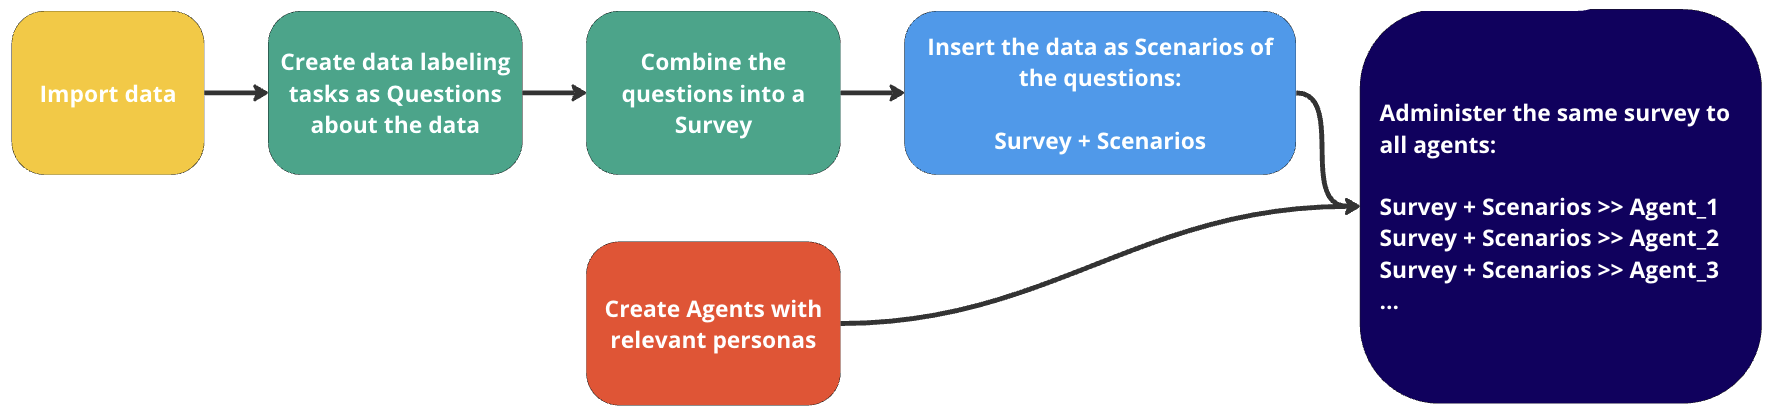
<br><br>

## Technical setup
Before running the code below please ensure that you have completed setup:

* [Install EDSL](https://docs.expectedparrot.com/en/latest/installation.html).
* Create a [Coop account](https://www.expectedparrot.com/login) and activate [remote inference](https://docs.expectedparrot.com/en/latest/remote_inference.html) OR store your own [API Keys](https://docs.expectedparrot.com/en/latest/api_keys.html) for language models that you want to use.

Our [Starter Tutorial](https://docs.expectedparrot.com/en/latest/starter_tutorial.html) also provides examples of EDSL basic components. 

## Selecting data for review
First we identify some data for review. Data can be created using the EDSL tools or imported from other sources. For purposes of this demo we import a set of hypothetical customer tickets for a transportation app:

In [1]:
tickets = [
    "I just realized I left my phone in the car on my last ride. Can you help me get it back?",
    "I'm unhappy with my recent experience. The driver was very rude and unprofessional.",
    "I was charged more than the estimated fare for my trip yesterday. Can you explain why?",
    "The car seat provided was not properly installed, and I felt my child was at risk. Please ensure driver training.",
    "My driver took a longer route than necessary, resulting in a higher fare. I request a fare adjustment.",
    "I had a great experience with my driver today! Very friendly and efficient service.",
    "I'm concerned about the vehicle's cleanliness. It was not up to the standard I expect.",
    "The app keeps crashing every time I try to book a ride. Please fix this issue.",
    "My driver was exceptional - safe driving, polite, and the car was spotless. Kudos!",
    "I felt unsafe during my ride due to the driver's erratic behavior. This needs to be addressed immediately.",
    "The driver refused to follow my preferred route, which is shorter. I'm not satisfied with the service.",
    "Impressed with the quick response to my ride request and the driver's professionalism.",
    "I was charged for a ride I never took. Please refund me as soon as possible.",
    "The promo code I tried to use didn't work. Can you assist with this?",
    "There was a suspicious smell in the car, and I'm worried about hygiene standards.",
    "My driver was very considerate, especially helping me with my luggage. Appreciate the great service!",
    "The app's GPS seems inaccurate. It directed the driver to the wrong pick-up location.",
    "I want to compliment my driver's excellent navigation and time management during rush hour.",
    "The vehicle didn't match the description in the app. It was confusing and concerning.",
    "I faced an issue with payment processing after my last ride. Can you look into this?",
]

## Constructing questions about the data
Next we create some questions about the data. EDSL provides a variety of question types that we can choose from based on the form of the response that we want to get back from the model (multiple choice, free text, checkbox, linear scale, etc.). [Learn more about question types](https://docs.expectedparrot.com/en/latest/questions.html). 

Note that we use a `{{ placeholder }}` in each question text in order to parameterize the questions with the individual ticket contents in the next step:

In [2]:
from edsl import (
    QuestionMultipleChoice,
    QuestionCheckBox,
    QuestionFreeText,
    QuestionList,
    QuestionYesNo,
    QuestionLinearScale,
)

In [3]:
question_issues = QuestionCheckBox(
    question_name="issues",
    question_text="Check all of the issues mentioned in this ticket: {{ ticket }}",
    question_options=[
        "safety",
        "cleanliness",
        "driver performance",
        "GPS/route",
        "lost item",
        "other",
    ],
)

In [4]:
question_primary_issue = QuestionFreeText(
    question_name="primary_issue",
    question_text="What is the primary issue in this ticket? Ticket: {{ ticket }}",
)

In [5]:
question_accident = QuestionMultipleChoice(
    question_name="accident",
    question_text="If the primary issue in this ticket is safety, was there an accident where someone was hurt? Ticket: {{ ticket }}",
    question_options=["Yes", "No", "Not applicable"],
)

In [6]:
question_sentiment = QuestionMultipleChoice(
    question_name="sentiment",
    question_text="What is the sentiment of this ticket? Ticket: {{ ticket }}",
    question_options=[
        "Very positive",
        "Somewhat positive",
        "Neutral",
        "Somewhat negative",
        "Very negative",
    ],
)

In [7]:
question_refund = QuestionYesNo(
    question_name="refund",
    question_text="Does the customer ask for a refund in this ticket? Ticket: {{ ticket }}",
)

In [8]:
question_priority = QuestionLinearScale(
    question_name="priority",
    question_text="On a scale from 0 to 5, what is the priority level of this ticket? Ticket: {{ ticket }}",
    question_options=[0, 1, 2, 3, 4, 5],
    option_labels={0: "Lowest", 5: "Highest"},
)

## Building a survey
We combine the questions into a survey in order to administer them together:

In [9]:
from edsl import Survey

survey = Survey(
    questions=[
        question_issues,
        question_primary_issue,
        question_accident,
        question_sentiment,
        question_refund,
        question_priority,
    ]
)

Survey questions are administered asynchronously by default. [Learn more about adding conditional logic and memory to your survey](https://docs.expectedparrot.com/en/latest/surveys.html).

We can review our questions in a readable format, or export them as a survey to use with human respondents or at other survey platforms:

In [10]:
survey

,option_labels,question_text,question_options,question_type,use_code,question_name
0,nan,Check all of the issues mentioned in this ticket: {{ ticket }},"['safety', 'cleanliness', 'driver performance', 'GPS/route', 'lost item', 'other']",checkbox,True,issues
1,nan,What is the primary issue in this ticket? Ticket: {{ ticket }},nan,free_text,nan,primary_issue
2,nan,"If the primary issue in this ticket is safety, was there an accident where someone was hurt? Ticket: {{ ticket }}","['Yes', 'No', 'Not applicable']",multiple_choice,nan,accident
3,nan,What is the sentiment of this ticket? Ticket: {{ ticket }},"['Very positive', 'Somewhat positive', 'Neutral', 'Somewhat negative', 'Very negative']",multiple_choice,nan,sentiment
4,nan,Does the customer ask for a refund in this ticket? Ticket: {{ ticket }},"['No', 'Yes']",yes_no,nan,refund
5,"{0: 'Lowest', 5: 'Highest'}","On a scale from 0 to 5, what is the priority level of this ticket? Ticket: {{ ticket }}","[0, 1, 2, 3, 4, 5]",linear_scale,nan,priority


## Designing AI agents
A key feature of EDSL is the ability to create personas for AI agents that the language models are prompted to use in generating responses to the questions. This is done by passing a dictionary of traits to Agent objects:

In [11]:
from edsl import Agent

agent = Agent(
    traits={
        "persona": "You are an expert customer service agent.",
        "years_experience": 15,
    }
)
agent

,key,value
0,traits:persona,You are an expert customer service agent.
1,traits:years_experience,15


## Selecting language models
EDSL allows us to select the language models to use in generating results. To see all available models:

In [12]:
from edsl import Model

Model.available()

/Users/a16174/edsl/edsl/inference_services/AvailableModelFetcher.py:139: UserWarning: No models found for service ollama
  warnings.warn(f"No models found for service {service_name}")


,Model Name,Service Name
0,test,test
1,claude-3-5-sonnet-20240620,anthropic
2,claude-3-opus-20240229,anthropic
3,claude-3-sonnet-20240229,anthropic
4,claude-3-haiku-20240307,anthropic
5,amazon.titan-text-express-v1,bedrock
6,amazon.titan-text-lite-v1,bedrock
7,anthropic.claude-3-5-sonnet-20240620-v1:0,bedrock
8,anthropic.claude-3-haiku-20240307-v1:0,bedrock
9,anthropic.claude-3-opus-20240229-v1:0,bedrock


Here we select GPT 4o (if no model is specified, the default model is used -- run `Model()` to verify the current default model):

In [13]:
model = Model("gpt-4o")
model

,key,value
0,model,gpt-4o
1,parameters:temperature,0.500000
2,parameters:max_tokens,1000
3,parameters:top_p,1
4,parameters:frequency_penalty,0
5,parameters:presence_penalty,0
6,parameters:logprobs,False
7,parameters:top_logprobs,3


## Adding data to the questions
We add the contents of each ticket into each question as an independent "scenario" for review. This allows us to create versions of the questions for each job post and deliver them to the model all at once:

In [14]:
from edsl import ScenarioList

scenarios = ScenarioList.from_list("ticket", tickets)
scenarios

,ticket
0,I just realized I left my phone in the car on my last ride. Can you help me get it back?
1,I'm unhappy with my recent experience. The driver was very rude and unprofessional.
2,I was charged more than the estimated fare for my trip yesterday. Can you explain why?
3,"The car seat provided was not properly installed, and I felt my child was at risk. Please ensure driver training."
4,"My driver took a longer route than necessary, resulting in a higher fare. I request a fare adjustment."
5,I had a great experience with my driver today! Very friendly and efficient service.
6,I'm concerned about the vehicle's cleanliness. It was not up to the standard I expect.
7,The app keeps crashing every time I try to book a ride. Please fix this issue.
8,"My driver was exceptional - safe driving, polite, and the car was spotless. Kudos!"
9,I felt unsafe during my ride due to the driver's erratic behavior. This needs to be addressed immediately.


## Running the survey
We run the survey by adding the scenarios, agent and model with the `by()` method and then calling the `run()` method:

In [15]:
results = survey.by(scenarios).by(agent).by(model).run()

Job UUID,89894324-ea41-4619-b77b-d98bee3d986b
Progress Bar URL,https://www.expectedparrot.com/home/remote-job-progress/89894324-ea41-4619-b77b-d98bee3d986b
Error Report URL,None
Results UUID,7aa62007-54b7-41a9-a769-81bed1013949
Results URL,None


This generates a formatted dataset of `Results` that includes information about all the components, including the prompts and responses. We can see a list of all the components:

In [16]:
results.columns

,0
0,agent.agent_instruction
1,agent.agent_name
2,agent.persona
3,agent.years_experience
4,answer.accident
5,answer.issues
6,answer.primary_issue
7,answer.priority
8,answer.refund
9,answer.sentiment


## Analyzing results
EDSL comes with [built-in methods for analyzing results](https://docs.expectedparrot.com/en/latest/results.html). Here we filter, sort, select and print components in a table:

In [17]:
(
    results
    .filter("priority in [4, 5]")
    .sort_by("issues", "sentiment")
    .select("ticket", "issues", "primary_issue", "accident", "sentiment", "refund", "priority")
)

,scenario.ticket,answer.issues,answer.primary_issue,answer.accident,answer.sentiment,answer.refund,answer.priority
0,The app's GPS seems inaccurate. It directed the driver to the wrong pick-up location.,['GPS/route'],"The primary issue in this ticket is the inaccuracy of the app's GPS, which resulted in directing the driver to the wrong pick-up location. This can lead to delays and inconvenience for both the driver and the customer, so it's important to address the GPS functionality to ensure it provides accurate directions.",No,Somewhat negative,No,4
1,The app keeps crashing every time I try to book a ride. Please fix this issue.,['other'],The primary issue in this ticket is that the app crashes whenever the user attempts to book a ride. The user is requesting a fix for this problem.,Not applicable,Somewhat negative,No,5
2,"The car seat provided was not properly installed, and I felt my child was at risk. Please ensure driver training.","['safety', 'driver performance']","The primary issue in this ticket is the improper installation of the car seat provided by the driver, which made the customer feel that their child's safety was at risk. The customer is requesting that drivers receive additional training to ensure proper car seat installation in the future.",No,Very negative,No,5
3,I felt unsafe during my ride due to the driver's erratic behavior. This needs to be addressed immediately.,"['safety', 'driver performance']",The primary issue in this ticket is the customer's feeling of being unsafe due to the driver's erratic behavior. This is a serious concern that requires immediate attention to ensure the safety of passengers and to address any potential misconduct by the driver.,Not applicable,Very negative,No,5


We can apply some lables to our table:

In [18]:
(
    results.select(
        "ticket",
        "issues",
        "primary_issue",
        "accident",
        "sentiment",
        "refund",
        "priority",
    ).print(
        pretty_labels={
            "scenario.ticket": "Ticket",
            "answer.issues": "Issues",
            "answer.primary_issue": "Primary issue",
            "answer.accident": "Accident",
            "answer.sentiment": "Sentiment",
            "answer.refund": "Refund request",
            "answer.priority": "Priority",
        }
    )
)

,Ticket,Issues,Primary issue,Accident,Sentiment,Refund request,Priority
0,I just realized I left my phone in the car on my last ride. Can you help me get it back?,['lost item'],The primary issue in this ticket is that the customer left their phone in a car during their last ride and needs assistance in retrieving it.,Not applicable,Somewhat negative,No,3
1,I'm unhappy with my recent experience. The driver was very rude and unprofessional.,['driver performance'],"The primary issue in this ticket is the customer's dissatisfaction with the behavior of the driver, who was described as rude and unprofessional. Addressing this concern involves acknowledging the customer's experience, apologizing for the inconvenience, and taking appropriate steps to ensure such behavior is not repeated in the future.",No,Very negative,No,3
2,I was charged more than the estimated fare for my trip yesterday. Can you explain why?,['other'],The primary issue in this ticket is that the customer was charged more than the estimated fare for their trip and is seeking an explanation for the discrepancy.,Not applicable,Somewhat negative,No,3
3,"The car seat provided was not properly installed, and I felt my child was at risk. Please ensure driver training.","['safety', 'driver performance']","The primary issue in this ticket is the improper installation of the car seat provided by the driver, which made the customer feel that their child's safety was at risk. The customer is requesting that drivers receive additional training to ensure proper car seat installation in the future.",No,Very negative,No,5
4,"My driver took a longer route than necessary, resulting in a higher fare. I request a fare adjustment.","['driver performance', 'GPS/route']","The primary issue in this ticket is that the customer believes the driver took a longer route than necessary, which led to a higher fare. The customer is requesting an adjustment to the fare to reflect what they believe should have been the correct amount.",No,Somewhat negative,No,2
5,I had a great experience with my driver today! Very friendly and efficient service.,['driver performance'],"It seems there is no issue in this ticket. Instead, it appears to be positive feedback about a great experience with the driver. It's always wonderful to receive compliments about friendly and efficient service!",Not applicable,Very positive,No,0
6,I'm concerned about the vehicle's cleanliness. It was not up to the standard I expect.,['cleanliness'],The primary issue in this ticket is the customer's concern about the cleanliness of the vehicle. They feel that the vehicle was not cleaned to the standard they expect. Addressing this issue would involve ensuring the vehicle is thoroughly cleaned and possibly offering an apology or compensation to the customer for their inconvenience.,No,Somewhat negative,No,2
7,The app keeps crashing every time I try to book a ride. Please fix this issue.,['other'],The primary issue in this ticket is that the app crashes whenever the user attempts to book a ride. The user is requesting a fix for this problem.,Not applicable,Somewhat negative,No,5
8,"My driver was exceptional - safe driving, polite, and the car was spotless. Kudos!","['safety', 'cleanliness', 'driver performance']","The primary issue in this ticket is not a complaint or problem, but rather positive feedback. The customer is expressing satisfaction with their driver, highlighting the driver's safe driving, politeness, and the cleanliness of the car. This is a commendation rather than an issue.",Not applicable,Very positive,No,0
9,I felt unsafe during my ride due to the driver's erratic behavior. This needs to be addressed immediately.,"['safety', 'driver performance']",The primary issue in this ticket is the customer's feeling of being unsafe due to the driver's erratic behavior. This is a serious concern that requires immediate attention to ensure the safety of passengers and to address any potential misconduct by the driver.,Not applic

EDSL also comes with methods for accessing results as a dataframe or SQL table:

In [19]:
df = (
    results
    .select(
        "issues",
        "primary_issue",
        "accident",
        "sentiment",
        "refund",
        "priority"
    )
    .to_pandas(remove_prefix=True)
)
df

,issues,primary_issue,accident,sentiment,refund,priority
0,['lost item'],The primary issue in this ticket is that the c...,Not applicable,Somewhat negative,No,3
1,['driver performance'],The primary issue in this ticket is the custom...,No,Very negative,No,3
2,['other'],The primary issue in this ticket is that the c...,Not applicable,Somewhat negative,No,3
3,"['safety', 'driver performance']",The primary issue in this ticket is the improp...,No,Very negative,No,5
4,"['driver performance', 'GPS/route']",The primary issue in this ticket is that the c...,No,Somewhat negative,No,2
5,['driver performance'],It seems there is no issue in this ticket. Ins...,Not applicable,Very positive,No,0
6,['cleanliness'],The primary issue in this ticket is the custom...,No,Somewhat negative,No,2
7,['other'],The primary issue in this ticket is that the a...,Not applicable,Somewhat negative,No,5
8,"['safety', 'cleanliness', 'driver performance']",The primary issue in this ticket is not a comp...,Not applicable,Very positive,No,0
9,"['safety', 'driver performance']",The primary issue in this ticket is the custom...,Not applicable,Very negative,No,5


We can also access results as a SQL table:

In [20]:
results.sql("""
select ticket, issues, primary_issue, accident, sentiment, refund, priority 
from self
""")

,ticket,issues,primary_issue,accident,sentiment,refund,priority
0,I just realized I left my phone in the car on my last ride. Can you help me get it back?,['lost item'],The primary issue in this ticket is that the customer left their phone in a car during their last ride and needs assistance in retrieving it.,Not applicable,Somewhat negative,No,3
1,I'm unhappy with my recent experience. The driver was very rude and unprofessional.,['driver performance'],"The primary issue in this ticket is the customer's dissatisfaction with the behavior of the driver, who was described as rude and unprofessional. Addressing this concern involves acknowledging the customer's experience, apologizing for the inconvenience, and taking appropriate steps to ensure such behavior is not repeated in the future.",No,Very negative,No,3
2,I was charged more than the estimated fare for my trip yesterday. Can you explain why?,['other'],The primary issue in this ticket is that the customer was charged more than the estimated fare for their trip and is seeking an explanation for the discrepancy.,Not applicable,Somewhat negative,No,3
3,"The car seat provided was not properly installed, and I felt my child was at risk. Please ensure driver training.","['safety', 'driver performance']","The primary issue in this ticket is the improper installation of the car seat provided by the driver, which made the customer feel that their child's safety was at risk. The customer is requesting that drivers receive additional training to ensure proper car seat installation in the future.",No,Very negative,No,5
4,"My driver took a longer route than necessary, resulting in a higher fare. I request a fare adjustment.","['driver performance', 'GPS/route']","The primary issue in this ticket is that the customer believes the driver took a longer route than necessary, which led to a higher fare. The customer is requesting an adjustment to the fare to reflect what they believe should have been the correct amount.",No,Somewhat negative,No,2
5,I had a great experience with my driver today! Very friendly and efficient service.,['driver performance'],"It seems there is no issue in this ticket. Instead, it appears to be positive feedback about a great experience with the driver. It's always wonderful to receive compliments about friendly and efficient service!",Not applicable,Very positive,No,0
6,I'm concerned about the vehicle's cleanliness. It was not up to the standard I expect.,['cleanliness'],The primary issue in this ticket is the customer's concern about the cleanliness of the vehicle. They feel that the vehicle was not cleaned to the standard they expect. Addressing this issue would involve ensuring the vehicle is thoroughly cleaned and possibly offering an apology or compensation to the customer for their inconvenience.,No,Somewhat negative,No,2
7,The app keeps crashing every time I try to book a ride. Please fix this issue.,['other'],The primary issue in this ticket is that the app crashes whenever the user attempts to book a ride. The user is requesting a fix for this problem.,Not applicable,Somewhat negative,No,5
8,"My driver was exceptional - safe driving, polite, and the car was spotless. Kudos!","['safety', 'cleanliness', 'driver performance']","The primary issue in this ticket is not a complaint or problem, but rather positive feedback. The customer is expressing satisfaction with their driver, highlighting the driver's safe driving, politeness, and the cleanliness of the car. This is a commendation rather than an issue.",Not applicable,Very positive,No,0
9,I felt unsafe during my ride due to the driver's erratic behavior. This needs to be addressed immediately.,"['safety', 'driver performance']",The primary issue in this ticket is the customer's feeling of being unsafe due to the driver's erratic behavior. This is a serious concern that requires immediate attention to ensure the safety of passengers and to address any potential misconduct by the driver.,Not applicable,Ver

To export results to a CSV file:

In [21]:
results.to_csv("data_labeling_example.csv")

FileStore(path='data_la...mple.csv', base64_string='YW5zd2V...bmcuIg0K', binary=False, suffix='csv', mime_type='text/csv', external_locations={}, extracted_text='answer....ng."\r\n')

## Posting content to the Coop
We can post any objects to the Coop, including this notebook. Objects can be updated or modified at your Coop account, and shared with others or stored privately (default visibility is *unlisted*):

In [22]:
results.push(description = "Customer service tickets data labeling example", visibility="public")

{'description': 'Customer service tickets data labeling example',
 'object_type': 'results',
 'url': 'https://www.expectedparrot.com/content/3b78afcd-14ba-4937-8280-1ac3487e16c1',
 'uuid': '3b78afcd-14ba-4937-8280-1ac3487e16c1',
 'version': '0.1.39.dev2',
 'visibility': 'public'}

In [23]:
survey.push(description = "Customer service tickets data labeling example survey", visibility="public")

{'description': 'Customer service tickets data labeling example survey',
 'object_type': 'survey',
 'url': 'https://www.expectedparrot.com/content/ebd0e9d6-53fa-4618-a527-e5e53b202d0c',
 'uuid': 'ebd0e9d6-53fa-4618-a527-e5e53b202d0c',
 'version': '0.1.39.dev2',
 'visibility': 'public'}

In [24]:
from edsl import Notebook

n = Notebook(path="data_labeling_example.ipynb")

info = n.push(description="Data labeling example", visibility="public") 
info

{'description': 'Data labeling example',
 'object_type': 'notebook',
 'url': 'https://www.expectedparrot.com/content/0d621ed9-a8b1-4a7b-a9a2-8e6dc09ab80d',
 'uuid': '0d621ed9-a8b1-4a7b-a9a2-8e6dc09ab80d',
 'version': '0.1.39.dev2',
 'visibility': 'public'}

To update an object at the Coop:

In [25]:
n = Notebook(path="data_labeling_example.ipynb") # resave

n.patch(uuid = info["uuid"], value = n)

{'status': 'success'}